In [1]:
import os
import pandas as pd 
import numpy as np
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

# Import pakages for machine learning
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

# Deep neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

## 0. Preprocess simple PHS files

> define `is_all_time` == True of False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]
phs_list = phs_list[1:] # remove new_match_map_stats.csv from the list

# choose all time or specific season
is_all_time = True # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[11] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

new_phs['team_DI'] = new_phs[new_phs['team_name'] == new_phs['team_one_name']]['team_one_DI']
new_phs['team_DI'].fillna(new_phs['team_two_DI'], inplace=True)

# select season
is_select_season = True # set True for selecting season
if is_select_season == True: 
    select_season=2020
    new_phs = new_phs[new_phs['season']==select_season]
else:
    select_season='all time'

# save mode
save_mode = True # set save mode true for saving results

## 1. Feature Engineering

> Define a `target_hero = All Heroes`

> remove features by `remove_feature`


In [110]:
hero_list = ['All Heroes', 'Orisa', 'Winston', 'L첬cio', 'Mercy', 'Hanzo', 'Junkrat', 'Tracer', 'Roadhog', 'Soldier: 76', 'Zenyatta', 'D.Va', 'Widowmaker', 'Zarya', 'Reinhardt', 'McCree', 'Pharah', 'Brigitte', 'Genji', 'Sombra', 'Reaper', 'Doomfist', 'Bastion', 'Mei', 'Moira', 'Torbj철rn', 'Ana', 'Symmetra', 'Sigma', 'Baptiste', 'Wrecking Ball', 'Ashe', 'Echo']

# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'team_DI', 'is_map_winner']]

# select target hero
target_hero = hero_list[5] # put 'All Heroes' for selecting all heroes
'''
'All Heroes' 'Orisa' 'Winston' 'L첬cio' 'Mercy' 'Hanzo' 'Junkrat' 'Tracer'
 'Roadhog' 'Soldier: 76' 'Zenyatta' 'D.Va' 'Widowmaker' 'Zarya'
 'Reinhardt' 'McCree' 'Pharah' 'Brigitte' 'Genji' 'Sombra' 'Reaper'
 'Doomfist' 'Bastion' 'Mei' 'Moira' 'Torbj철rn' 'Ana' 'Symmetra' 'Sigma'
 'Baptiste' 'Wrecking Ball' 'Ashe' 'Echo'
'''
# data selection
df = df[df['hero_name'] == target_hero]
df = df.groupby(['esports_match_id', 'team_name', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner', 'team_DI']].mean()
df = df.unstack()

# drop if time played is below than `min_play_time` per map
min_play_time = 300 # set minimum play time to make a cut
df = df[df[('stat_amount','Time Played')] > min_play_time]

# get `is_map_winner`
is_map_winner = df[('is_map_winner', 'Time Played')]
is_map_winner.rename('is_map_winner', inplace=True)

# get team_DI
team_DI = df[('team_DI', 'Time Played')]
team_DI.fillna(0.5, inplace=True) # replace nan to 0.5. `there was 2 nan values in whole owl season data`
team_DI.rename('team_DI', inplace=True)

# check nan value
print(f'num of nan in is_map_winner: {is_map_winner.isna().sum()}')
print(f'len of is_map_winner: {len(is_map_winner)}')
print(f'num of nan in team_DI: {team_DI.isna().sum()}')
print(f'len of team_DI: {len(team_DI)}')

# engineer stats
df.drop(('is_map_winner',), axis=1, inplace=True) # drop is_map_winner column and leave only stat
df.drop(('team_DI',), axis=1, inplace=True) # drop team_DI column and leave only stat
df = df.xs('stat_amount', level=0, axis=1) # drop multilevel index

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # Always remove these features
common_stats = ['Deaths', 'Final Blows', 'Objective Time', 'Assists', 'Objective Kills', 'All Damage Done', 'Melee Percentage of Final Blows', 'Hero Damage Done', 'Melee Final Blows', 'Ultimates Used', 'Healing Done', 'Defensive Assists', 'Barrier Damage Done', 'Shots Fired', 'Weapon Accuracy', 'Multikills', 'Time Building Ultimate', 'Solo Kills', 'Time Holding Ultimate', 'Damage Blocked', 'Damage - Quick Melee', 'Time Elapsed per Ultimate Earned', 'Offensive Assists', 'Environmental Kills', 'Environmental Deaths', 'Recon Assists', 'Eliminations', 'Damage Taken'] # Stats of 'All Heroes'
if target_hero != 'All Heroes':
    remove_feature.extend(common_stats) # remove common feature if target hero is not All Heroes

df = df[df.columns.difference(remove_feature)]

# data cleansing
df.fillna(0, inplace=True)
print(f'num of nan in df: {df.isna().sum().sum()}')
print(f'len of df: {df.shape[0]}')

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner', 'team_DI'])].div(df['Time Played'], axis=0) * 600 # 10 min avg
print(f'num nan values in df_10min: {df_10min.isna().sum().sum()}')
print(f'len of df_10min: {df_10min.shape[0]}')

num of nan in is_map_winner: 0
len of is_map_winner: 152
num of nan in team_DI: 0
len of team_DI: 152
num of nan in df: 0
len of df: 152
num nan values in df_10min: 0
len of df_10min: 152


In [111]:
# Hero color
hero_hex_color = {'All Heroes':'#a9a9a9', 'Ana':'#718ab3', 'Bastion':'#7c8f7b', 'Brigitte':'#be736e', 'D.Va':'#ed93c7', 'Doomfist':'#815049', 'Genji':'#97ef43', 'Hanzo':'#b9b48a', 'Junkrat':'#ecbd53', 'L첬cio':'#85c952', 'McCree':'#ae595c', 'Mei':'#6faced', 'Mercy':'#ebe8bb', 'Moira':'#803c51', 'Orisa':'#468c43', 'Pharah':'#3e7dca', 'Reaper':'#7d3e51', 'Reinhardt':'#929da3', 'Roadhog':'#b68c52', 'Soldier: 76':'#697794', 'Sombra':'#7359ba', 'Symmetra':'#8ebccc', 'Torbj철rn':'#c0726e', 'Tracer':'#d79342', 'Widowmaker':'#9e6aa8', 'Winston':'#a2a6bf', 'Zarya':'#e77eb6', 'Zenyatta':'#ede582'}

In [112]:
# color owl team colors
import pickle

with open('owl_colors.pickle', 'rb') as fr:
    owl_colors = pickle.load(fr)

owl_colors_dict = {}

for team in owl_colors.keys():
    fullName = owl_colors[team]['fullName']
    mainColor = owl_colors[team]['secondaryColor'] # get main team color here
    color_in_hex = owl_colors[team]['colors'][mainColor]['hex']
    print(fullName, mainColor, color_in_hex)
    owl_colors_dict.update({fullName:color_in_hex})

owl_colors_dict

Dallas Fuel strongBlue #0072CE
Atlanta Reign darkRed #910F1B
Boston Uprising yellow #EFDF00
Chengdu Hunters lightBrown #B4926A
Florida Mayhem pink #CF4691
Los Angeles Gladiators black #000000
Guangzhou Charge darkCyan #67A2B2
Houston Outlaws green #97D700
Hangzhou Spark blue #5788CE
London Spitfire orange #FF8200
New York Excelsior blue #0F57EA
Paris Eternal darkPink #8D042D
Philadelphia Fusion gray #DCDCDC
Seoul Dynasty gold #AA8A00
San Francisco Shock gray #A5ACAF
Shanghai Dragons black #000000
Toronto Defiant red #C10021
Los Angeles Valiant yellow #FFD100
Vancouver Titans green #2FB228
Washington Justice darkBlue #003768


{'Dallas Fuel': '#0072CE',
 'Atlanta Reign': '#910F1B',
 'Boston Uprising': '#EFDF00',
 'Chengdu Hunters': '#B4926A',
 'Florida Mayhem': '#CF4691',
 'Los Angeles Gladiators': '#000000',
 'Guangzhou Charge': '#67A2B2',
 'Houston Outlaws': '#97D700',
 'Hangzhou Spark': '#5788CE',
 'London Spitfire': '#FF8200',
 'New York Excelsior': '#0F57EA',
 'Paris Eternal': '#8D042D',
 'Philadelphia Fusion': '#DCDCDC',
 'Seoul Dynasty': '#AA8A00',
 'San Francisco Shock': '#A5ACAF',
 'Shanghai Dragons': '#000000',
 'Toronto Defiant': '#C10021',
 'Los Angeles Valiant': '#FFD100',
 'Vancouver Titans': '#2FB228',
 'Washington Justice': '#003768'}

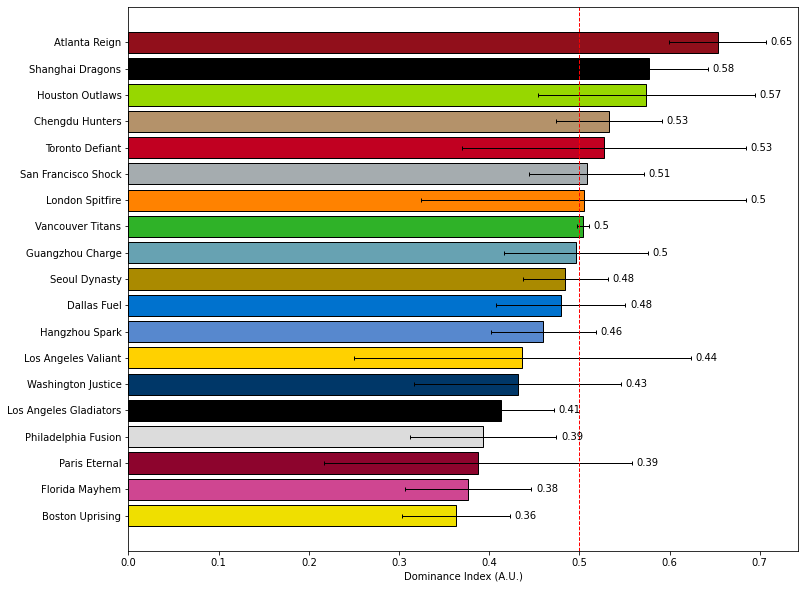

In [113]:
team_rank_df = pd.concat([df, team_DI], axis=1)

team_rank_df = team_rank_df.groupby(by='team_name')['team_DI'].agg(['mean', 'std', 'sem'])
team_rank_df = team_rank_df.sort_values(by='mean', ascending=True)
team_rank_df['color'] = team_rank_df.index.map(owl_colors_dict)
# display(team_rank_df)

plt.figure(figsize=(12,10))
plt.barh(team_rank_df.index.values, team_rank_df['mean'], color=team_rank_df['color'], edgecolor='black', xerr=team_rank_df['sem'], error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
plt.axvline(0.5, 0, 1, color='red', linestyle='--', linewidth=1) # add vertical line on DI=0.5
for i in team_rank_df.index:
    plt.text(team_rank_df.loc[i, 'mean']+team_rank_df.loc[i, 'sem']+0.005, i, round(team_rank_df.loc[i, 'mean'], 2), horizontalalignment='left', verticalalignment='center')

plt.xlabel('Dominance Index (A.U.)')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}DI_team_ranking.png', bbox_inches='tight')

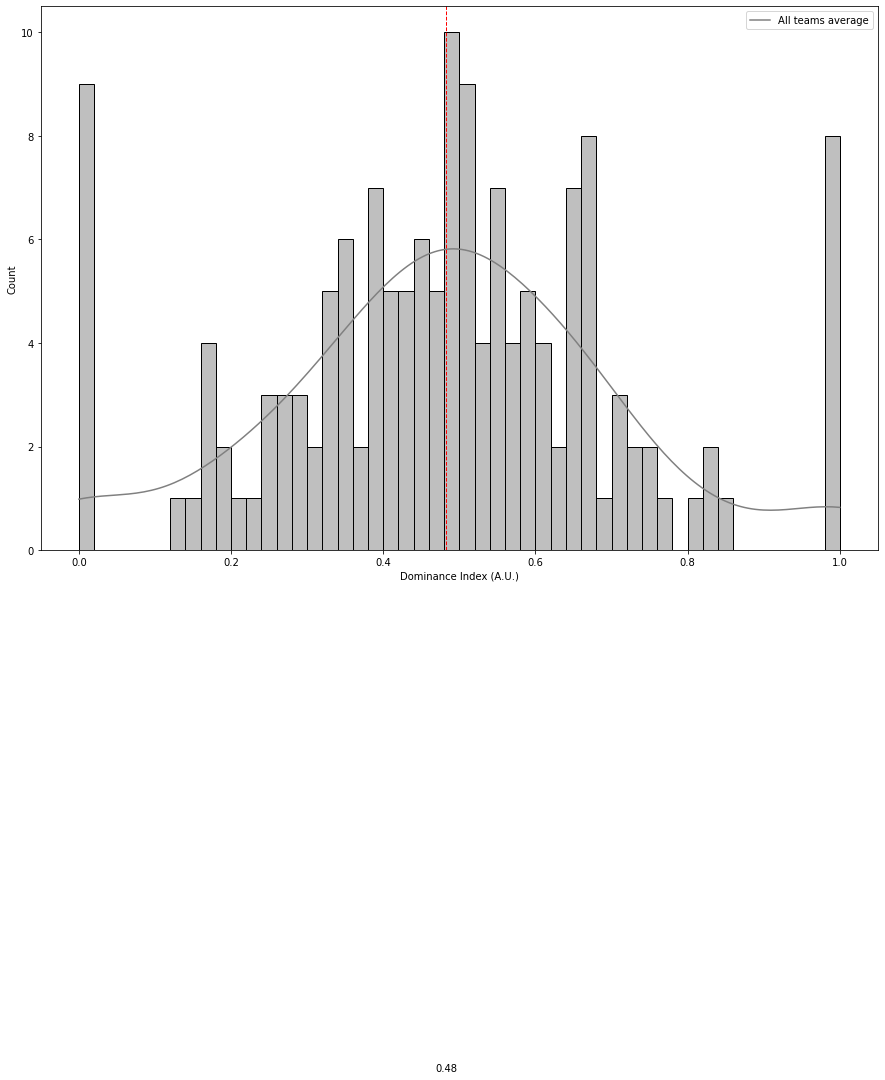

In [114]:
# plot all team's average DI distribution
team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=team_rank_df_by_time, x='team_DI', kde=True, color='gray', bins=50)
plt.axvline(team_rank_df_by_time['team_DI'].mean(), 0, 1, linewidth=1, color='red', linestyle='--') # mark avg line
plt.text(team_rank_df_by_time['team_DI'].mean(), -10, round(team_rank_df_by_time['team_DI'].mean(), 2), horizontalalignment='center', verticalalignment='center') # avg value
plt.xlabel('Dominance Index (A.U.)')
plt.legend(['All teams average'])

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}All_teams_DI_distribution.png', bbox_inches='tight')

In [116]:
# plot team's DI distribution
try:
    target_team = 'New York Excelsior'
    team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
    f = team_rank_df_by_time.xs(target_team, level='team_name')
    fig, ax = plt.subplots(figsize=(15,10))
    sns.histplot(data=f, x='team_DI', kde=True, ax=ax, color=owl_colors_dict[target_team], bins=50)
    plt.axvline(f['team_DI'].mean(), 0, 1, linewidth=1, color='red', linestyle='--') # mark avg line
    plt.text(f['team_DI'].mean(), -1, round(f['team_DI'].mean(), 2), horizontalalignment='center', verticalalignment='center') # avg value
    plt.xlabel('Dominance Index (A.U.)')
    plt.legend([target_team])

    # save
    if save_mode == True:
        save_path = f'./result/{select_season}/{target_hero}/'
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(f'{save_path}{target_team}_DI_distribution.png', bbox_inches='tight')
except:
    print('there is no New York Excelsior data')

there is no New York Excelsior data


In [118]:
# plot team's DI history
try:
    team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
    f = team_rank_df_by_time.xs('New York Excelsior', level='team_name')
    x = np.arange(0,len(f))
    plt.figure(figsize=(5,5))
    plt.plot(x, f['team_DI'], linewidth=1)

    # smoothing by moving window method
    window = f['team_DI'].rolling(window=20)
    y_smooth = window.mean()
    # plt.figure(figsize=(5,5))
    plt.plot(x, y_smooth, 'r', linewidth=1)
    plt.ylim(0,1)
except:
    print('these is no New York Excelsior data')

these is no New York Excelsior data


## Data Transform

In [119]:
# Data Transform
X_real = df
y_real = team_DI

X_10min = df_10min
y_10min = team_DI
# Select X, y data type
'''
0: real
1: 10min
'''
# save data type here
data_type = []
data_type.append([X_real, y_real])
data_type.append([X_10min, y_10min])

X, y = data_type[1] # select data type with index
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X shape: (152, 20)
y shape: (152,)
(121, 20) (31, 20) (121,) (31,)


## 2. Data Analysis

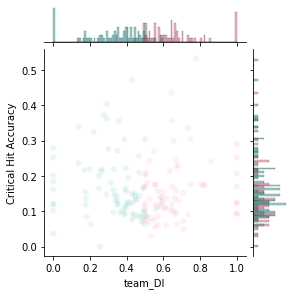

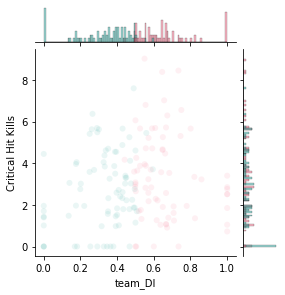

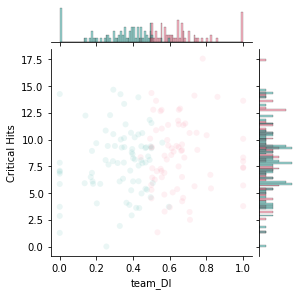

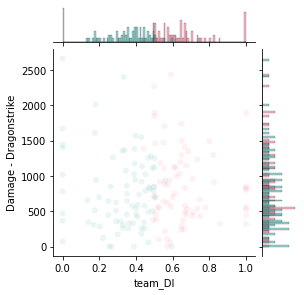

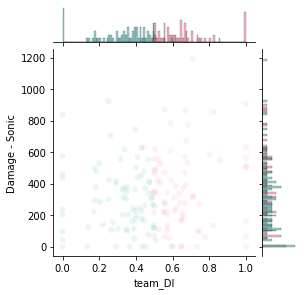

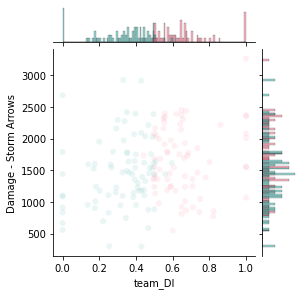

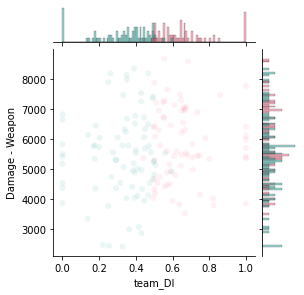

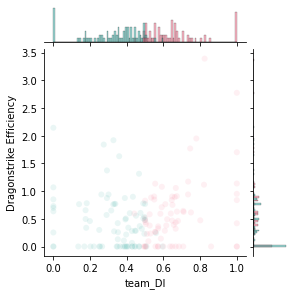

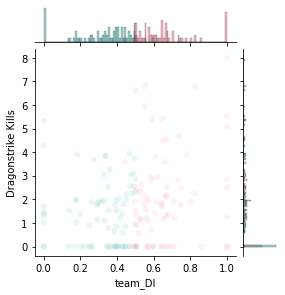

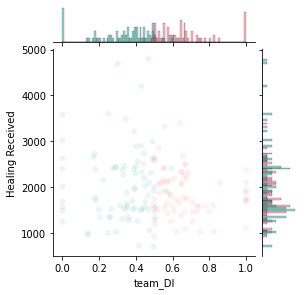

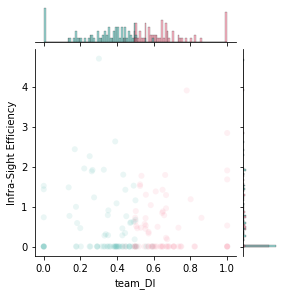

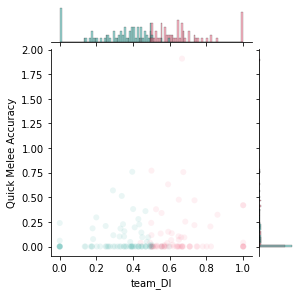

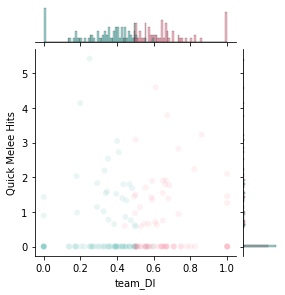

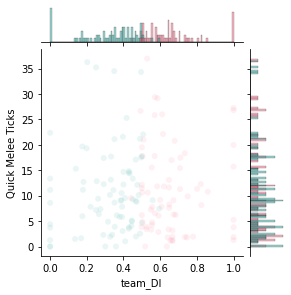

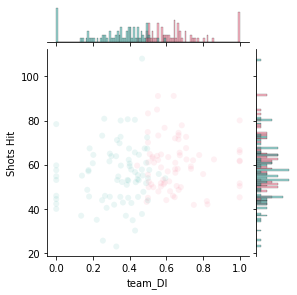

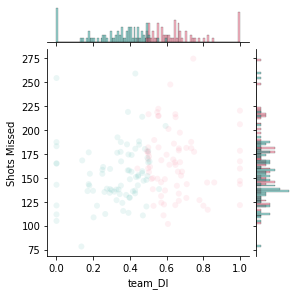

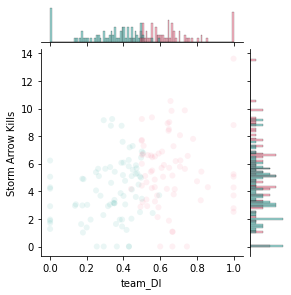

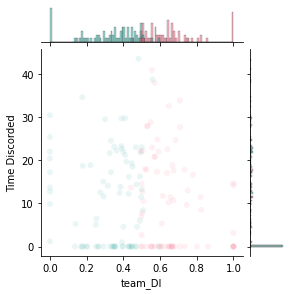

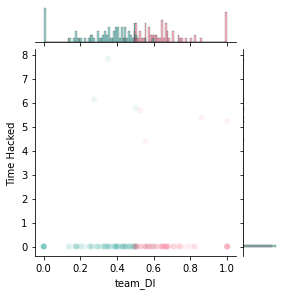

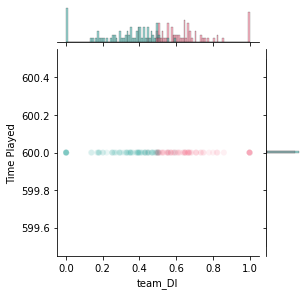

In [120]:
for stat in X.columns:
    g = sns.JointGrid(height=4)
    sns.scatterplot(x=y, y=X[stat], ax=g.ax_joint, hue=is_map_winner, palette='husl', legend=False, alpha=0.1)
    sns.histplot(x=y, ax=g.ax_marg_x, hue=is_map_winner, palette='husl', legend=False, alpha=0.5, bins=100)
    sns.histplot(y=X[stat], ax=g.ax_marg_y, hue=is_map_winner, palette='husl', legend=False, alpha=0.5, bins=100)

    # save
    if save_mode == True:
        save_path = f'./result/{select_season}/{target_hero}/stat-DI_correlation/'
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(f'{save_path}{stat}.png', bbox_inches='tight')

## 3. Regression Model

(121, 20) (31, 20) (121,) (31,)
20
1/1 [==============================] - 0s 14ms/step - loss: 0.0313 - mae: 0.1506
evaluation: [0.03128090873360634, 0.15059562027454376]


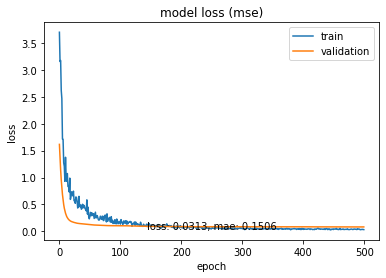

In [121]:
# check input and target shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
num_input_node = X_train.shape[1]
print(num_input_node)

# Setup a model
model = Sequential()
# 1st layer
model.add(Dense(20, activation='relu', input_shape=(num_input_node,)))
model.add(Dropout(0.3))
# 2nd layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(1)) # No activation function because this is regression, not classification

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
epochs = 500
history = model.fit(X_train, y_train, validation_split=0.25, epochs=epochs, verbose=0) # set num of epochs

# Evaluate the model
evaluation = model.evaluate(x=X_test, y=y_test)
print(f'evaluation: {evaluation}')

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.text(epochs/2, 0.1, f'loss: {round(evaluation[0], 4)}, mae: {round(evaluation[1], 4)}', ha='center', va='center')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}model_training.png', bbox_inches='tight')

In [122]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, view=False, filename='network visualization/network.gv', title='Dominance Index regression network model')

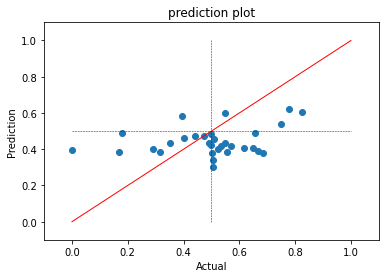

In [123]:
# plot predictions
y_pred = model.predict(X_test).flatten()
y_actual = y_test
plt.scatter(x=y_actual, y=y_pred)
plt.plot((0,1),(0,1), 'r', linewidth=1) # plot x=y line
plt.plot((0,1),(0.5,0.5), 'b--', linewidth=0.5) # plot grid
plt.plot((0.5,0.5),(0,1), 'b--', linewidth=0.5) # plot grid
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title('prediction plot')
plt.ylabel('Prediction')
plt.xlabel('Actual')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}prediction_plot.png', bbox_inches='tight')

## 4. SHAP interpretation

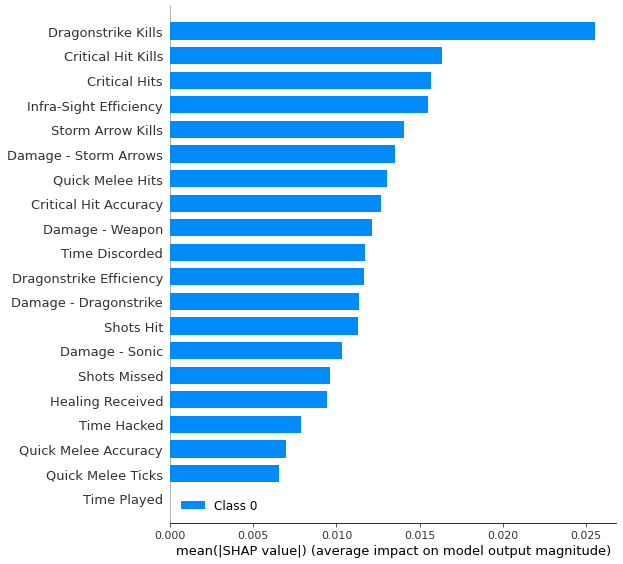

In [124]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model
explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

#
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar')


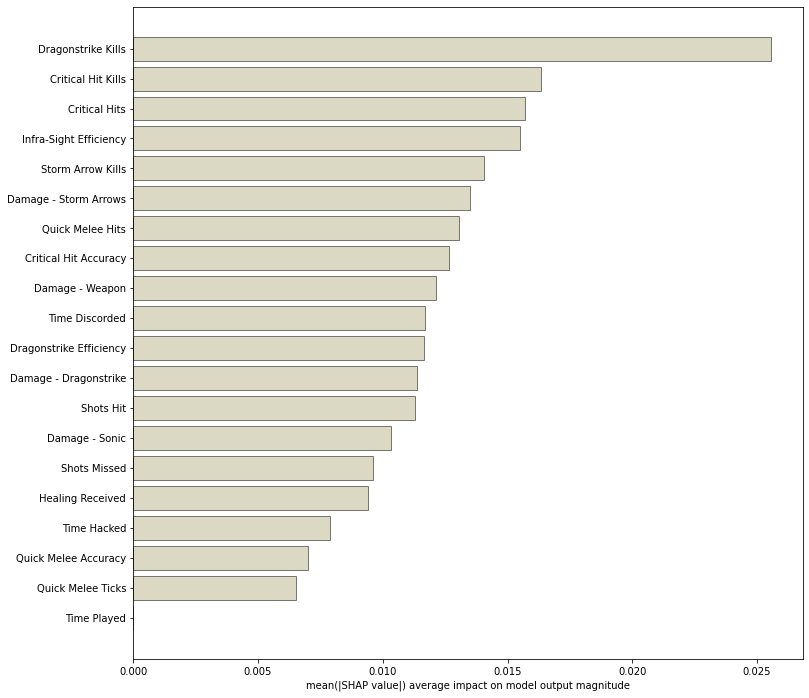

In [125]:
# Plot SHAP
df_shap = pd.DataFrame(shap_values[0], columns = X.columns)
df_shap = abs(df_shap)
df_shap = df_shap.mean()
df_shap = df_shap.sort_values()

plt.figure(figsize=(12,12))
plt.barh(df_shap.index.values, df_shap, alpha = 0.5, color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1)
plt.xlabel('mean(|SHAP value|) average impact on model output magnitude')

# get most important stat (max SHAP value)
most_important_stat = df_shap.index.values[-1]

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}SHAP_ranking.png', bbox_inches='tight')

## Player's stat ranking

In [126]:
target_stat = most_important_stat

# data collection
df_player_stat = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'team_DI', 'is_map_winner']]

# data selection
df_player_stat = df_player_stat[df_player_stat['hero_name'] == target_hero]
df_player_stat = df_player_stat.groupby(['esports_match_id', 'player_name', 'map_name', 'stat_name'])['stat_amount'].mean()
df_player_stat = df_player_stat.unstack()

# drop if time played is below than `min_play_time` per map
df_player_stat = df_player_stat[df_player_stat[('Time Played')] > min_play_time]
df_player_stat = df_player_stat[[target_stat, 'Time Played']]

# data cleansing
df_player_stat.fillna(0, inplace=True)
print(f'num of nan in df_player_stat: {df_player_stat.isna().sum().sum()}')
print(f'len of df_player_stat: {df_player_stat.shape[0]}')

# career total
df_player_stat_career = df_player_stat.groupby(level='player_name').sum()
df_player_stat_career = round(df_player_stat_career, 2)

display(df_player_stat_career)

# 10 min average
df_player_stat_10min = df_player_stat.div(df_player_stat['Time Played'], axis=0) * 600 # 10 min avg
df_player_stat_10min = df_player_stat_10min.groupby(level='player_name').mean()
df_player_stat_10min = round(df_player_stat_10min, 2)

# cut by career total play time
cut_time = df_player_stat_career['Time Played'].max() / 10 # remove players who played less than cut_time
print(f'cut time: {cut_time} s')
df_player_stat_10min = df_player_stat_10min[df_player_stat_career['Time Played'] >= cut_time]

display(df_player_stat_10min)

num of nan in df_player_stat: 0
len of df_player_stat: 154


stat_name    Dragonstrike Kills  Time Played
player_name                                 
Architect                   3.0       955.88
Babel                       3.0      1663.34
Baconjack                   0.0       370.85
Birdring                    4.0      1525.24
ColourHex                   0.0       442.87
Corey                       7.0      2832.39
Dalton                      2.0       625.77
Decay                       4.0      1209.81
Doha                        5.0      1164.07
Edison                      2.0       791.25
Fits                       20.0      3150.65
Fleta                      16.0      2518.95
GodsB                       6.0      4747.81
Happy                      10.0      3275.35
Heesu                       4.0       811.65
Jaru                        2.0      1057.92
Jerry                      30.0      7289.16
JinMu                       8.0      3106.77
KSP                         1.0       801.01
LIP                        21.0      7128.50
Leave                       4.0      3907.85
LiNkzr                     13.0      3693.75
Profit                     41.0      8079.77
STRIKER                    25.0      6695.66
Shax                        2.0       307.52
Stitch                      1.0      1358.80
Surefour                    6.0      1274.10
Tsuna                       5.0       963.63
Ttuba                       2.0       730.03
Xzi                         2.0      1886.24
babybay                    15.0      4540.58
bqb                        12.0      3636.34
carpe                      11.0      4008.89
ivy                         8.0      2637.76
nero                        5.0       984.07
sHockWave                   2.0      1022.96

cut time: 807.9770000000001 s


stat_name    Dragonstrike Kills  Time Played
player_name                                 
Architect                  1.86        600.0
Babel                      1.23        600.0
Birdring                   1.57        600.0
Corey                      1.65        600.0
Decay                      2.34        600.0
Doha                       2.58        600.0
Fits                       2.96        600.0
Fleta                      3.88        600.0
GodsB                      0.68        600.0
Happy                      1.79        600.0
Heesu                      2.96        600.0
Jaru                       1.22        600.0
Jerry                      2.18        600.0
JinMu                      1.32        600.0
LIP                        1.78        600.0
Leave                      0.69        600.0
LiNkzr                     1.99        600.0
Profit                     2.72        600.0
STRIKER                    1.99        600.0
Stitch                     0.46        600.0
Surefour                   2.64        600.0
Tsuna                      3.11        600.0
Xzi                        0.67        600.0
babybay                    1.70        600.0
bqb                        1.95        600.0
carpe                      1.64        600.0
ivy                        1.64        600.0
nero                       2.54        600.0
sHockWave                  1.17        600.0

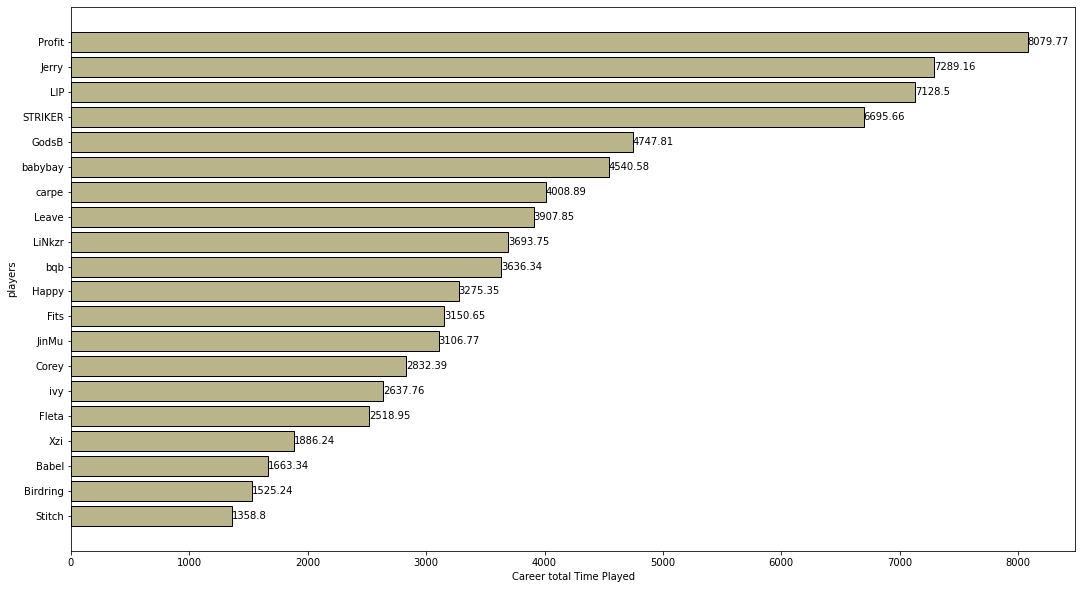

In [127]:
# Time Played Ranking
df_fig = df_player_stat_career.sort_values('Time Played', ascending=False)

# Top ranking
top_ranking = 20 # set ranking for showing
if len(df_fig) >= top_ranking:
   df_fig = df_fig.iloc[0:top_ranking]

df_fig = df_fig.sort_values('Time Played', ascending=True)

plt.figure(figsize=(18,10))
plt.barh(df_fig.index.values, df_fig['Time Played'], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'Career total Time Played')
for i in df_fig.index: # add values on bar graph
   plt.text(df_fig.loc[i, 'Time Played'], i, df_fig.loc[i, 'Time Played'], 
   horizontalalignment='left', 
   verticalalignment='center')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}Career_total_Time Played_top_{top_ranking}.png', bbox_inches='tight')

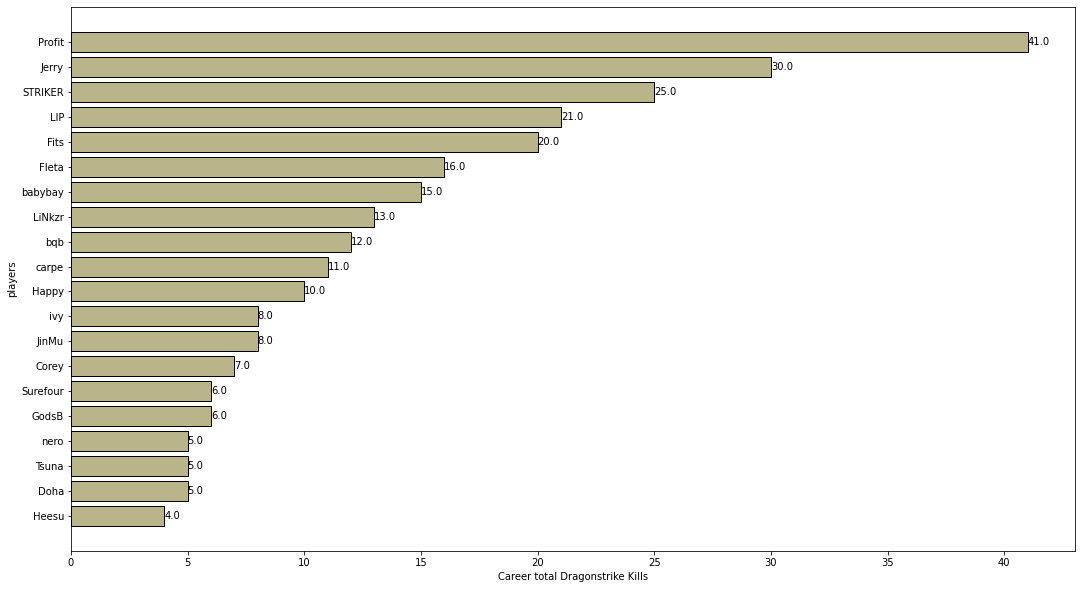

In [128]:
# set ranking in order
df_fig = df_player_stat_career.sort_values(target_stat, ascending=False)

# Top ranking
top_ranking = 20 # set ranking for showing
if len(df_fig) >= top_ranking:
   df_fig = df_fig.iloc[0:top_ranking]

df_fig = df_fig.sort_values(target_stat, ascending=True)

plt.figure(figsize=(18,10))
plt.barh(df_fig.index.values, df_fig[target_stat], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'Career total {target_stat}')
for i in df_fig.index: # add values on bar graph
   plt.text(df_fig.loc[i, target_stat], i, df_fig.loc[i, target_stat], 
   horizontalalignment='left', 
   verticalalignment='center')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}{target_stat}_player_career_total_top_{top_ranking}.png', bbox_inches='tight')

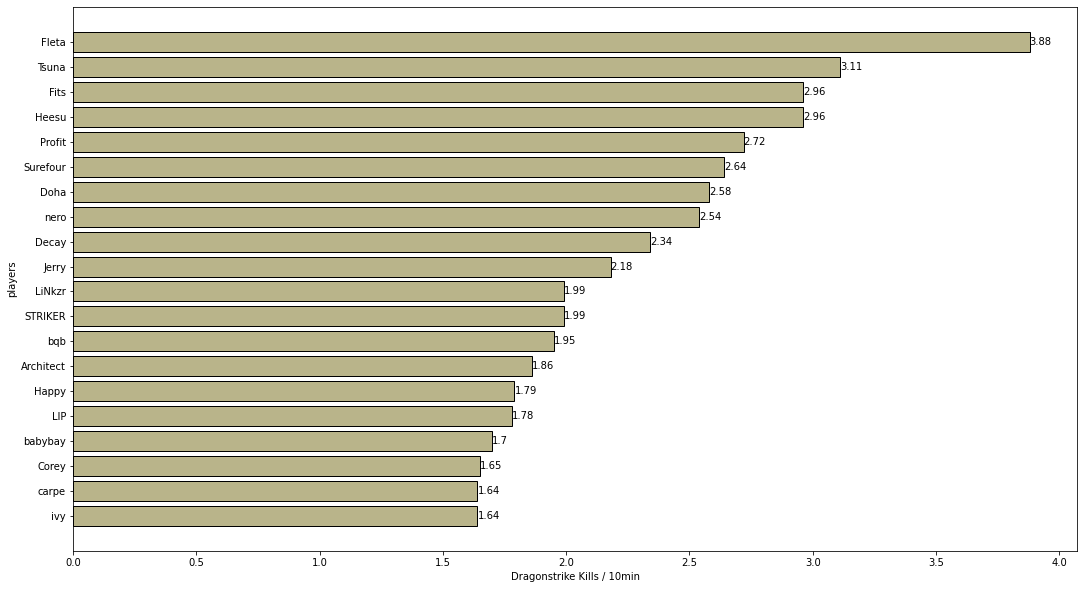

In [129]:
# /10min ranking
df_fig = df_player_stat_10min.sort_values(target_stat, ascending=False)

# Top ranking
top_ranking = 20 # set ranking for showing
if len(df_fig) >= top_ranking:
   df_fig = df_fig.iloc[0:top_ranking]

df_fig = df_fig.sort_values(target_stat, ascending=True)

plt.figure(figsize=(18,10))
plt.barh(df_fig.index.values, df_fig[target_stat], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'{target_stat} / 10min')
for i in df_fig.index: # add values on bar graph
   plt.text(df_fig.loc[i, target_stat], i, df_fig.loc[i, target_stat], 
   horizontalalignment='left', 
   verticalalignment='center')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}{target_stat}_player_10min_top_{top_ranking}.png', bbox_inches='tight')

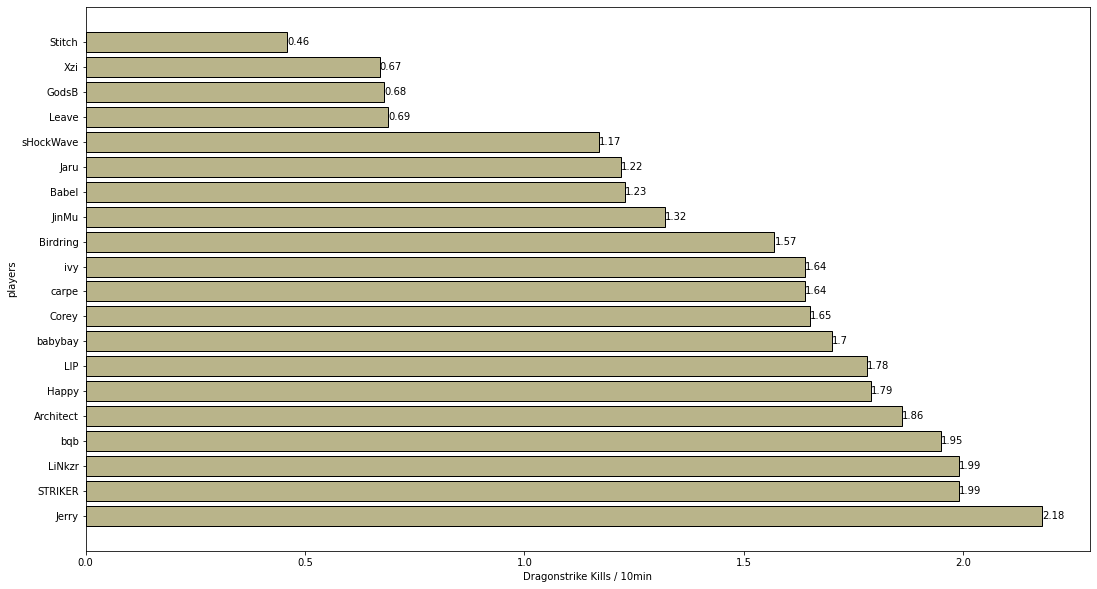

In [130]:
# reverse 10 min
# set ranking in order
df_fig = df_player_stat_10min.sort_values(target_stat, ascending=True)

# Top ranking
top_ranking = 20 # set ranking for showing
if len(df_fig) >= top_ranking:
   df_fig = df_fig.iloc[0:top_ranking]

df_fig = df_fig.sort_values(target_stat, ascending=False)

plt.figure(figsize=(18,10))
plt.barh(df_fig.index.values, df_fig[target_stat], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'{target_stat} / 10min')
for i in df_fig.index: # add values on bar graph
   plt.text(df_fig.loc[i, target_stat], i, df_fig.loc[i, target_stat], 
   horizontalalignment='left', 
   verticalalignment='center')

# save
if save_mode == True:
    save_path = f'./result/{select_season}/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(f'{save_path}{target_stat}_player_reverse_10min_top_{top_ranking}.png', bbox_inches='tight')